In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


hydra.initialize()

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [292]:
# import tifffile
# img_paths = sorted(glob.glob(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'))
# img_stack = np.stack([load_tiff_image(p) for p in img_paths], 0)
# img_stack = img_stack.reshape([16,1,2048, 2048], order='F')
# tifffile.imsave(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff', data=img_stack)

In [5]:
# scale_facs = np.array([104.83 ,  87.186,  89.545, 107.29 ,  83.262,  79.469,  78.451, 67.742,  45.66 ,  41.184,  44.731,  50.718,  44.572,  41.757, 45.019,  44.622])

In [593]:
cfg = compose(config_name='train.yaml', overrides= ["exp_type=merfish"])
cfg = OmegaConf.create(cfg)

In [594]:
thetas = [0.287,0.216,0.377,0.321,0.278,0.255,0.483,0.219,0.616,0.374,0.394,0.358,0.44,0.414,0.447,0.244]

Make dataset specific changes

In [595]:
cfg.output.project = 'MERFISH_starfish'
# cfg.output.group='sweep_sl_4'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

cfg.exp_type.pred_z = False
cfg.exp_type.const_theta_sim = True
cfg.exp_type.phasing = False

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [11,21,21]
cfg.PSF.gauss_radii = 1.7
cfg.PSF.n_cols = 1
# cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf.tif'

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.05

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 92
cfg.model.depth = 3
cfg.training.bs = 3
cfg.noise.theta = thetas

cfg.roi_mask.percentile = 20

cfg.microscope.norm = 'none'
cfg.microscope.psf_noise = 0.3
cfg.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.intensity_dist.int_conc = 4.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = .5

cfg.training.num_iters = 50000
cfg.training.int.enabled = False

cfg.training.mic.enabled = True
cfg.training.shuffle_ch = False

cfg.training.bl_loss_scale: 0.005

cfg.model.code_inf = True
cfg.training.net.min_int_sig = 1.0
cfg.run_name ='MERFISH_ci_2d_ae4'
cfg.microscope.scale = 60
cfg.bg_estimation.fractal.scale = 0

In [596]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_ci_2d_ae4'

In [95]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name={cfg.sub_name}')

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_ci_2d_sl3 run_name=scaled_nofoci


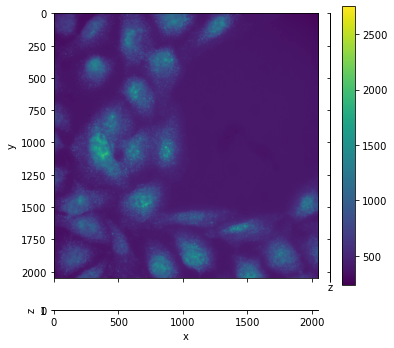

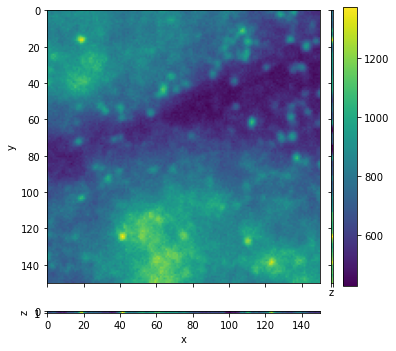

In [407]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[0][None]
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

In [76]:
from scipy import stats
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_vals = fit_vals[fit_vals > np.percentile(fit_vals, 100-percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

In [77]:
img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(16):
    bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img[i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img[i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

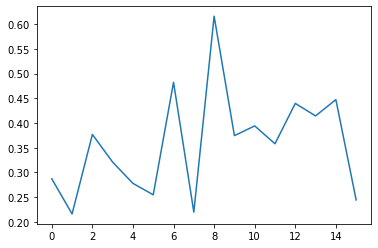

In [78]:
plt.plot(thetas)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [409]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

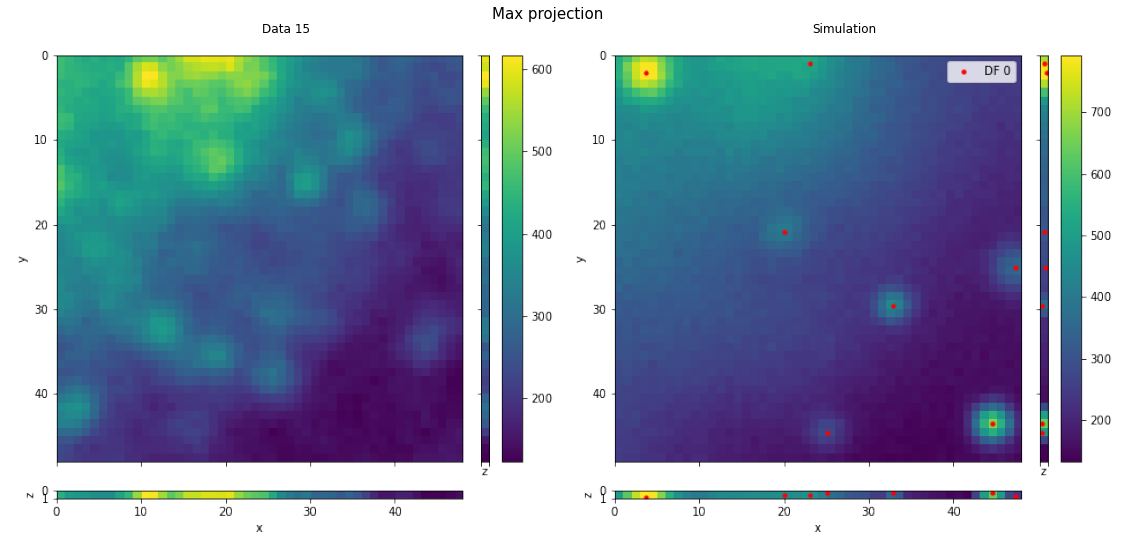

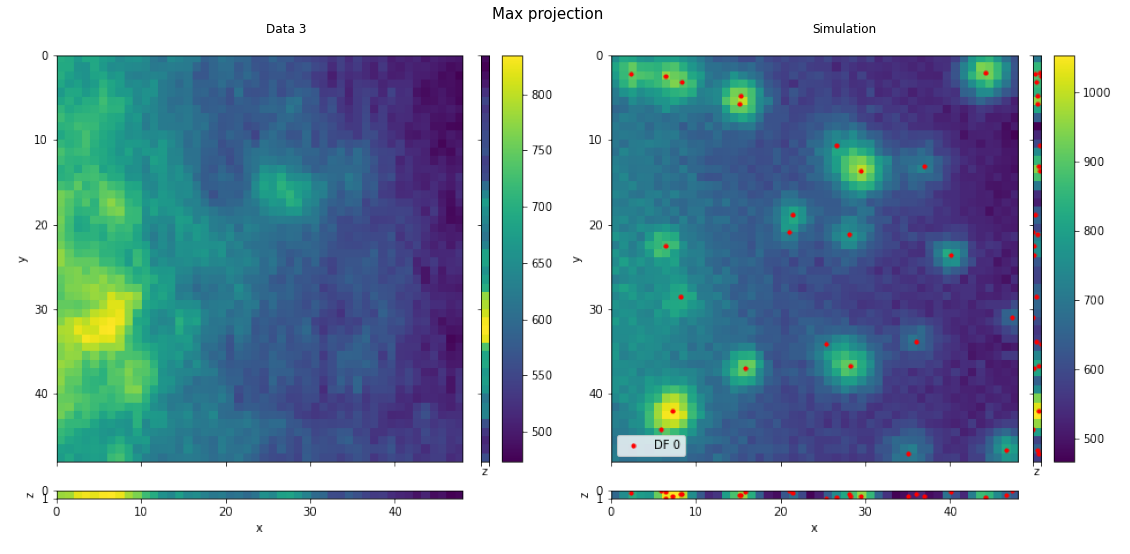

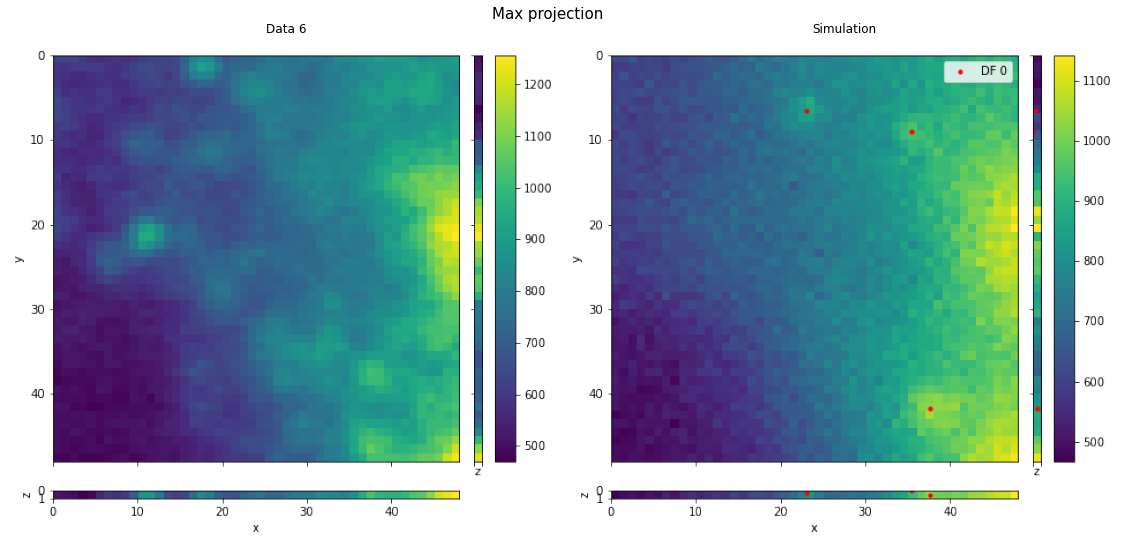

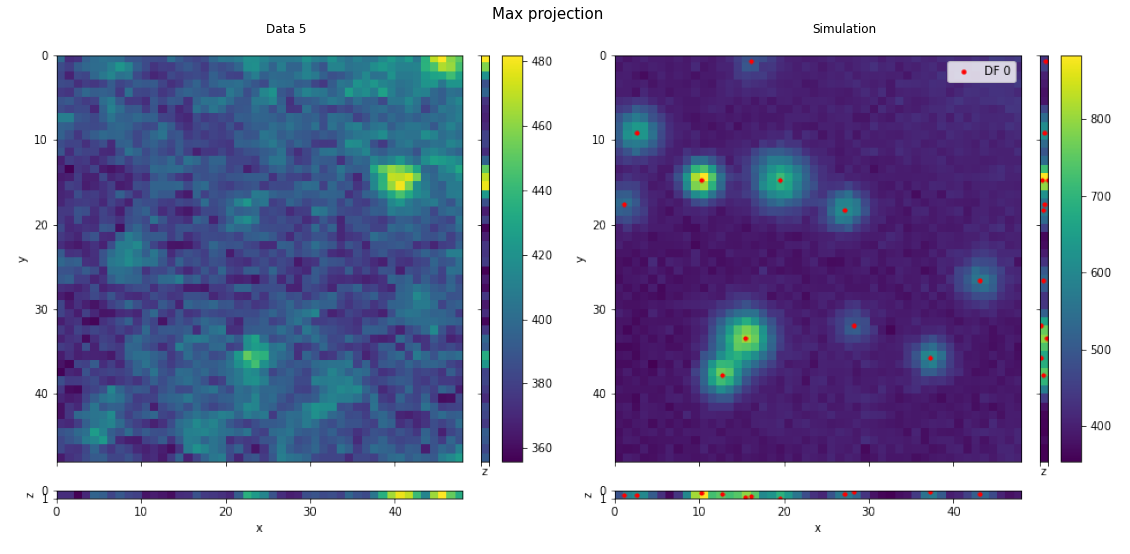

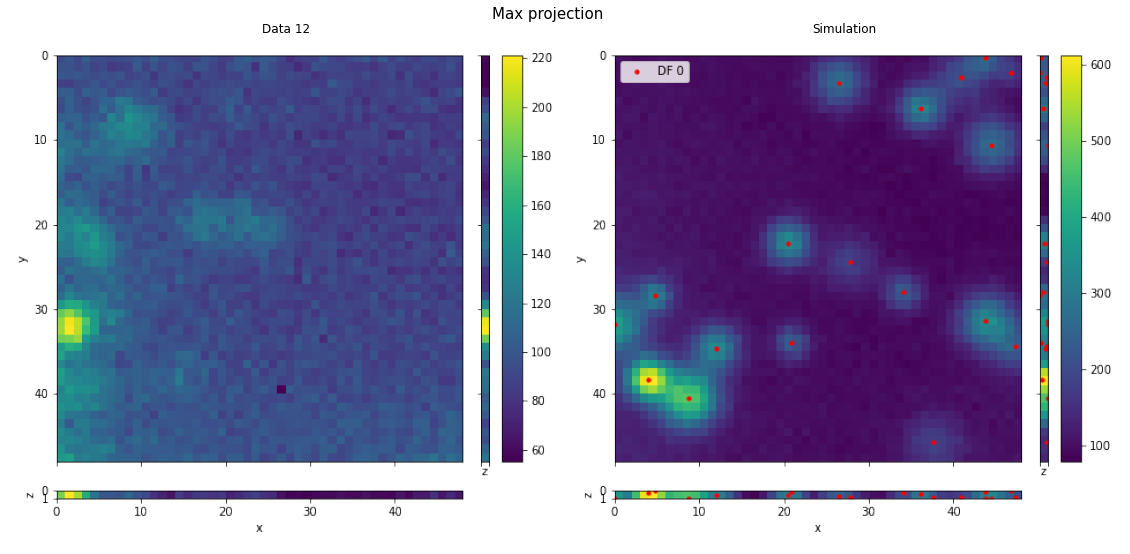

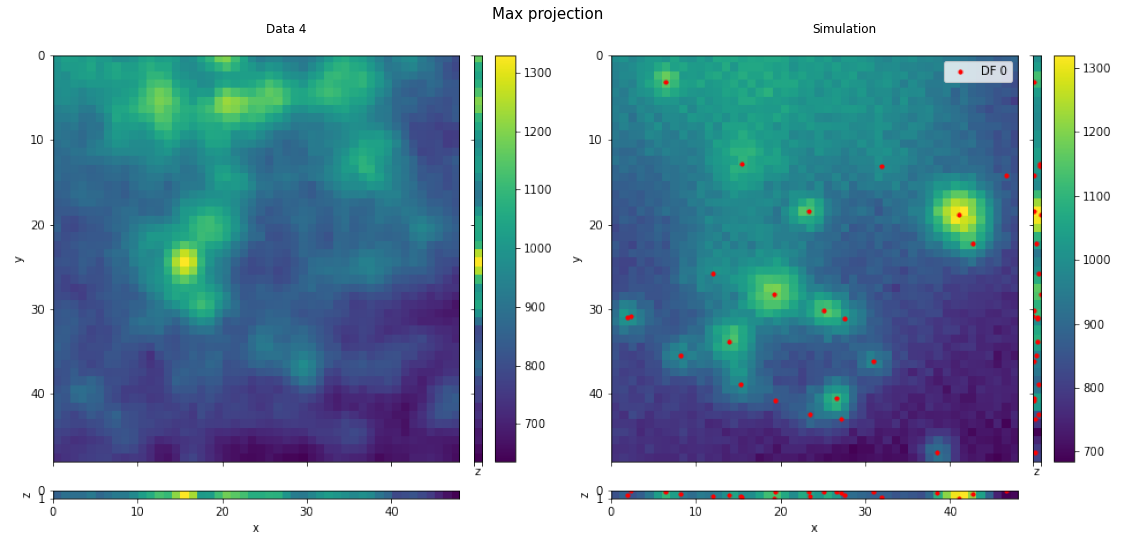

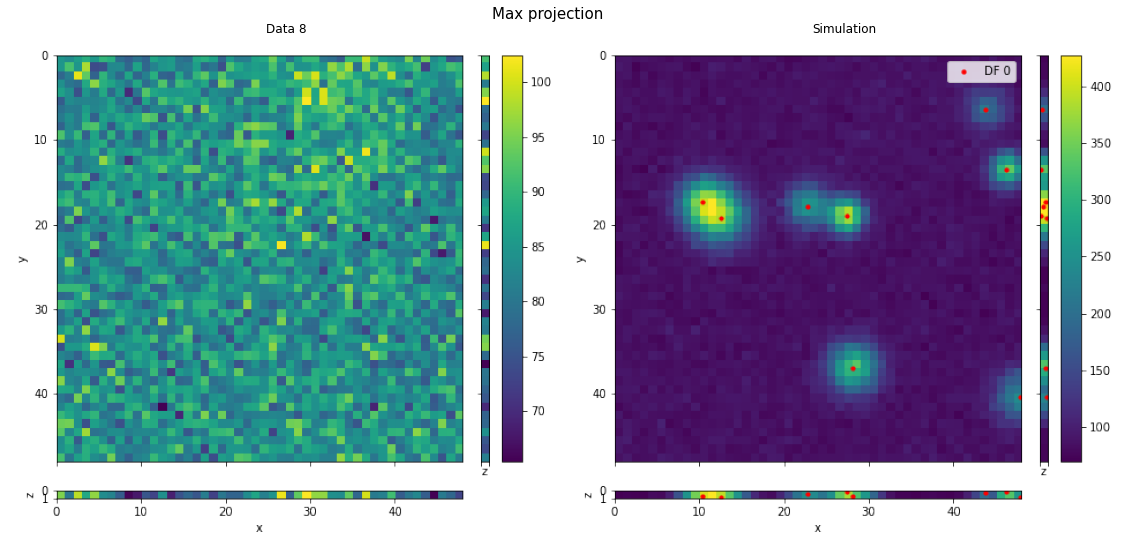

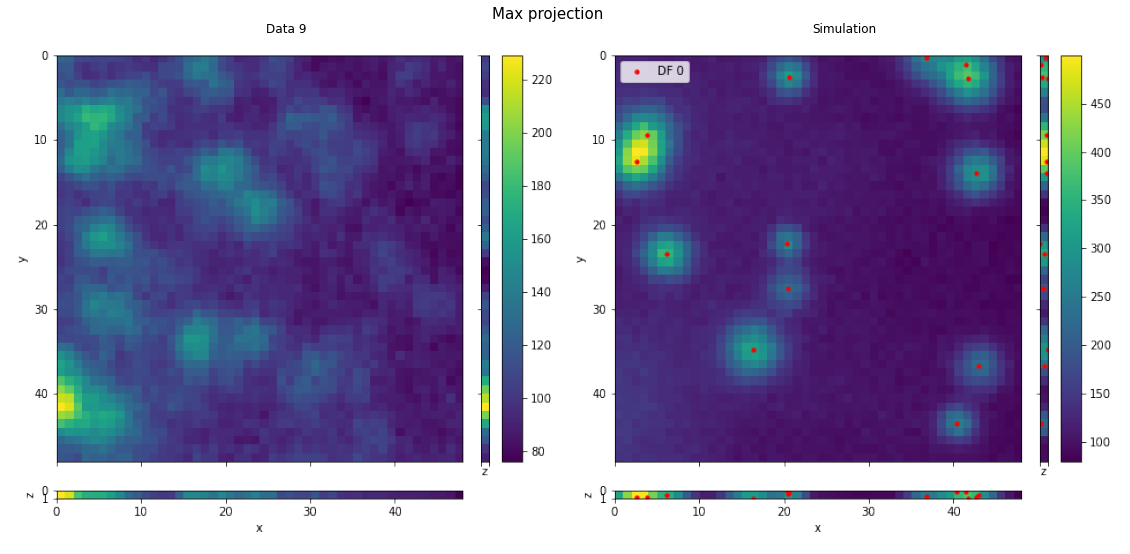

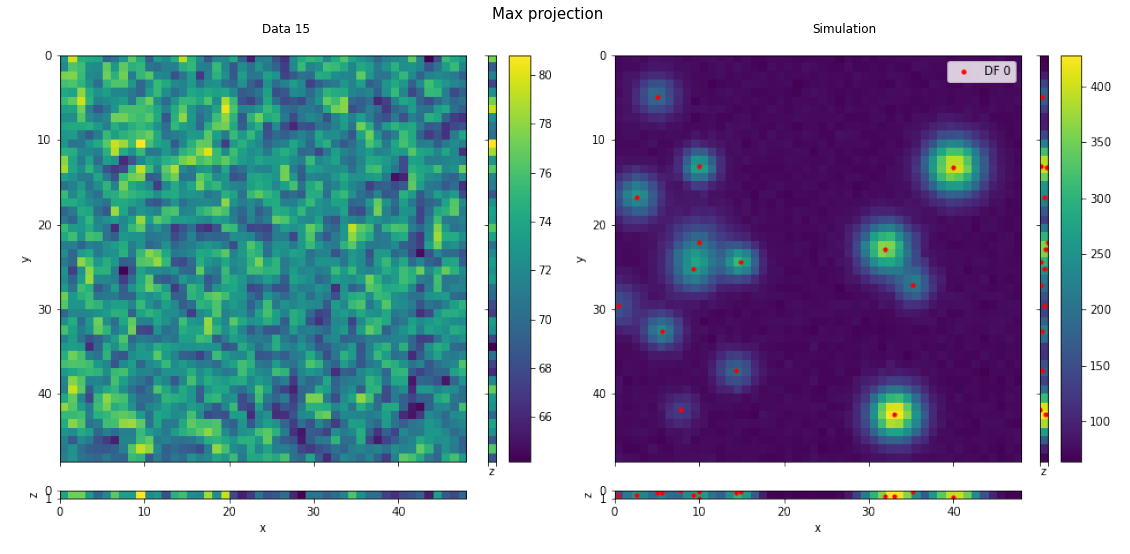

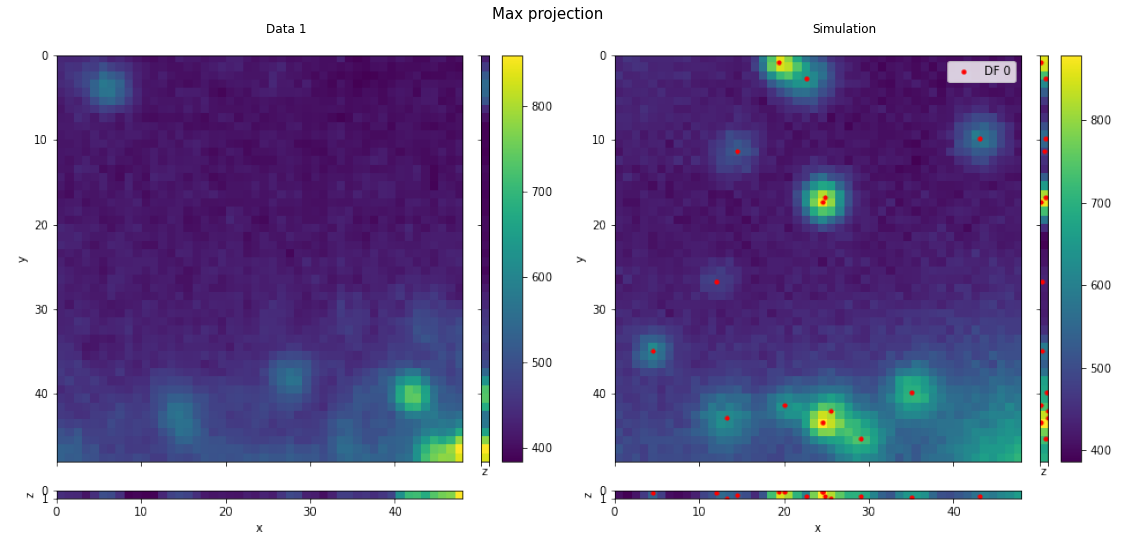

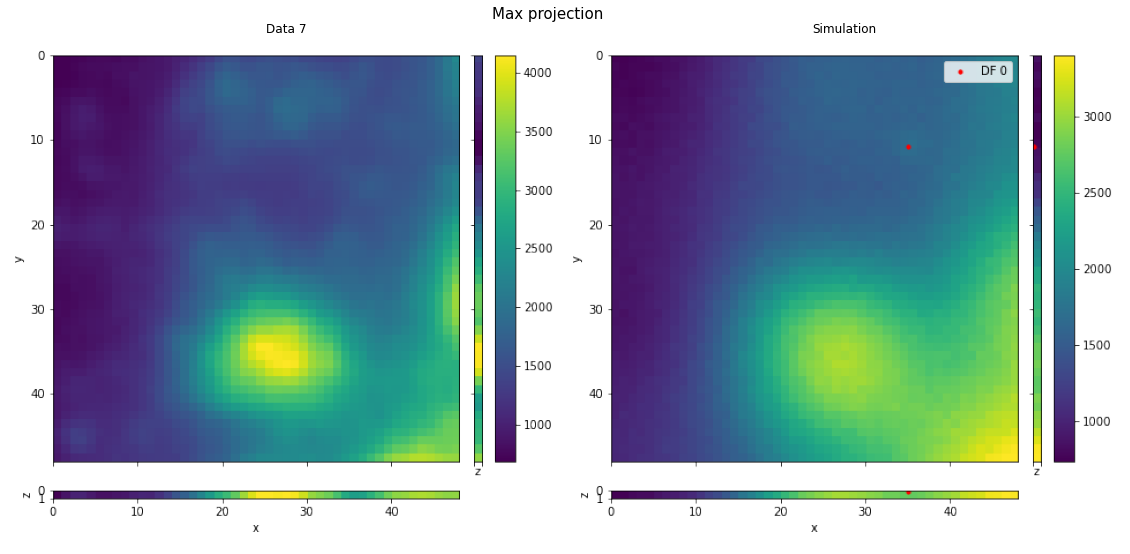

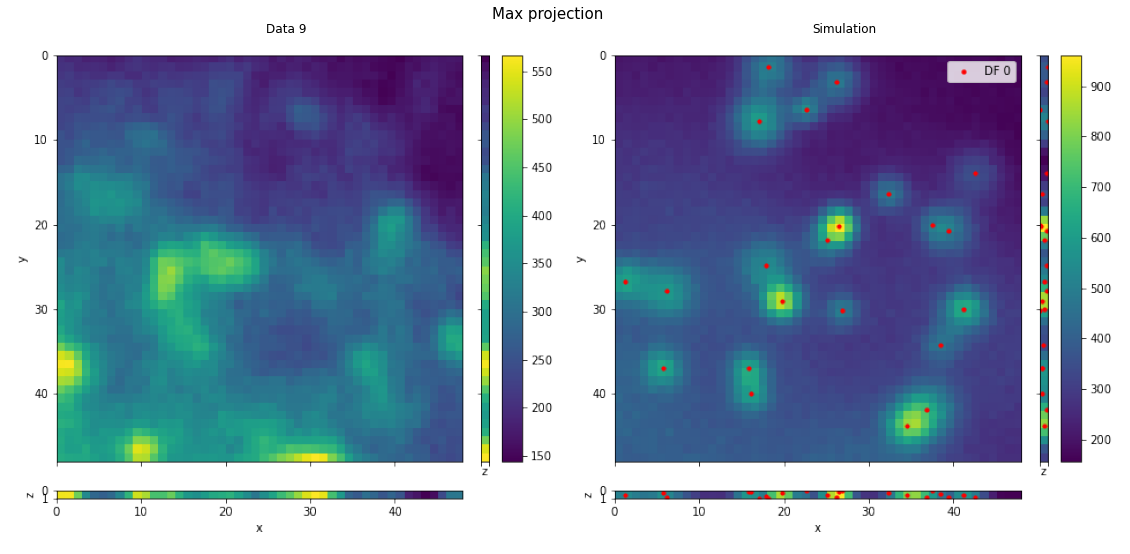

In [410]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=0.1, samples=12, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits, psf_noise=False)

# Evaluation

In [581]:
# cfg.run_name = 'test'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_14/enabled:Truexsample_from_codebook:Truexpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ae_2/shuffle_ch:Falsexenabled:Truexseed:1///train.yaml')


In [582]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]

In [583]:
# cfg.exp_type.pred_z = False

In [584]:
# Load the model, post processing, imgages, dataloader
cfg.PSF.n_cols=1
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# model, post_proc, _, _, _= load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii, cfg.exp_type.pred_z, cfg.PSF.n_cols)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(0., device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))


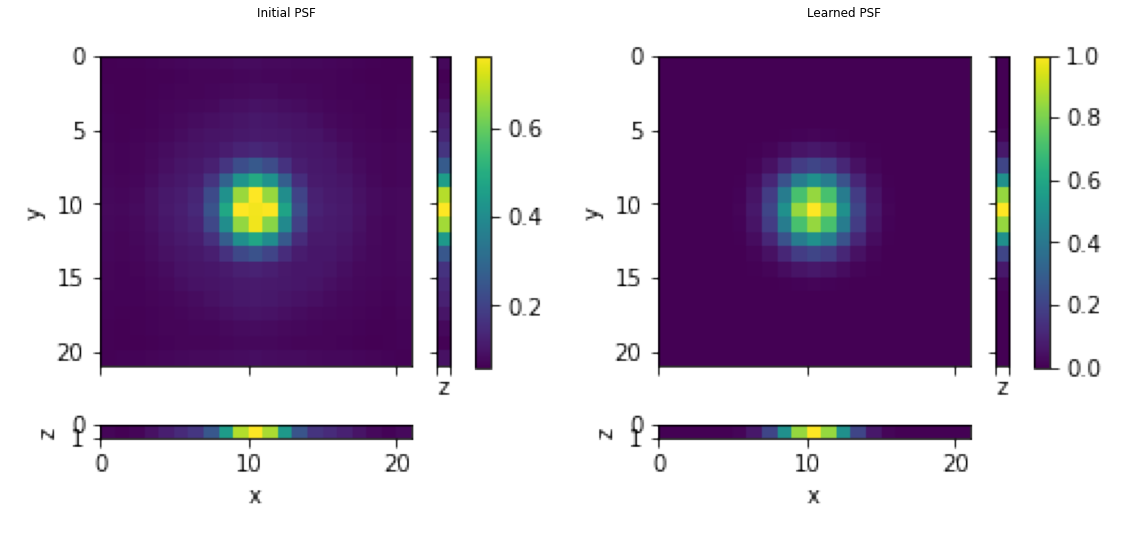

In [585]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

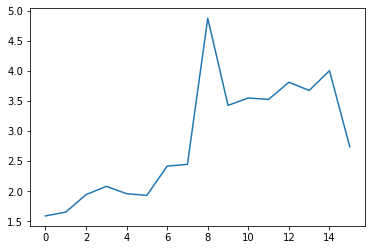

In [586]:
# plt.subplot(121)
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))
# plt.plot(ref_theta)

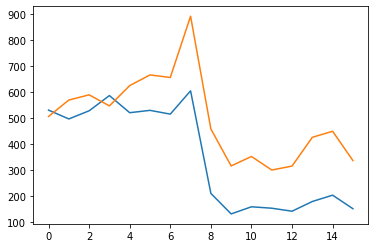

In [602]:
plt.plot(img_stack_o.mean(-1).mean(-1).mean(-1))
plt.plot(img_stack_s.mean(-1).mean(-1).mean(-1))

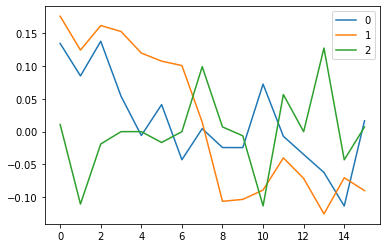

In [587]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [15]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, channel=0):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)

        
        if return_rec:
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, channel=channel)
            ae_img_3d = micro(locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, rec_ch=channel)   
            return pred_df, ae_img_3d + res_dict['background'][:,channel:channel+1], res_dict
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        decode_dl.dataset.dataset_tfms[0].crop_sz = (decode_dl.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                
            rand_ch = np.random.randint(0, x.shape[1])
            
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            pred_df = pred_df[pred_df[f'int_{rand_ch}'] > 0.03]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
        if ret_preds:
            
            return x, pred_df, rec, res_dict

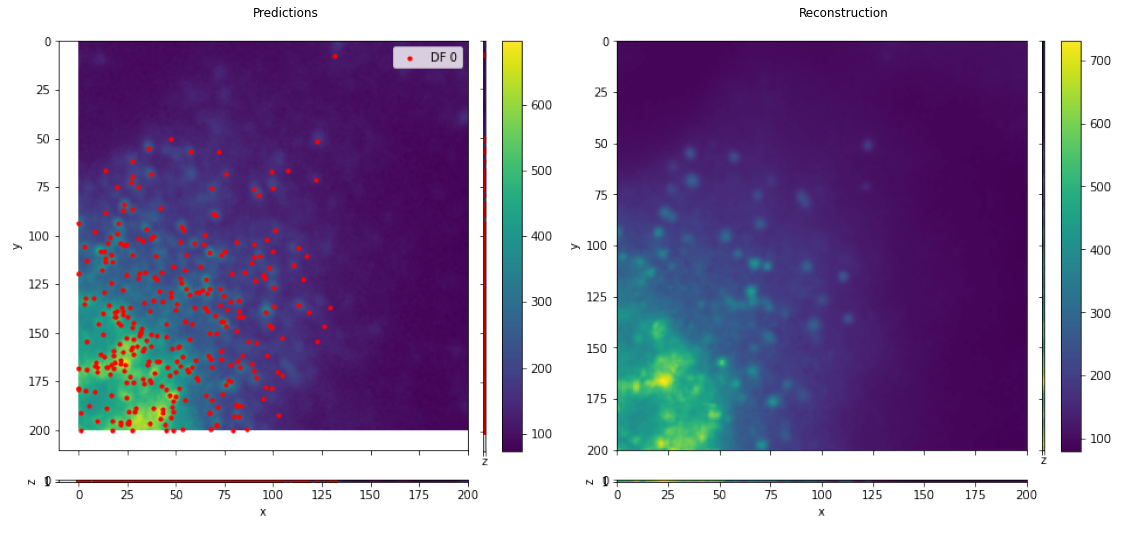

In [16]:
x, pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=200, ret_preds=True)

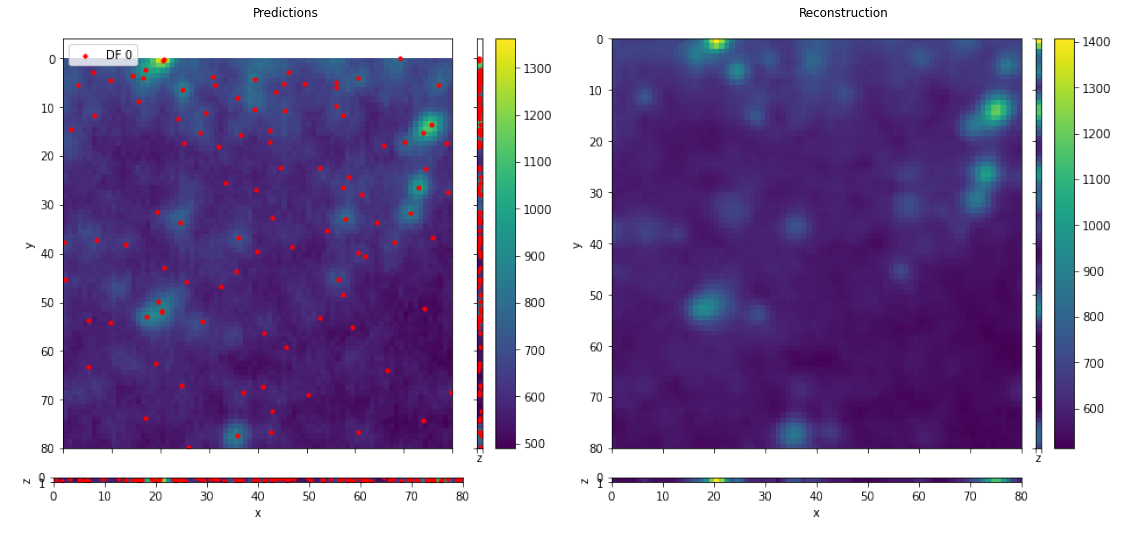

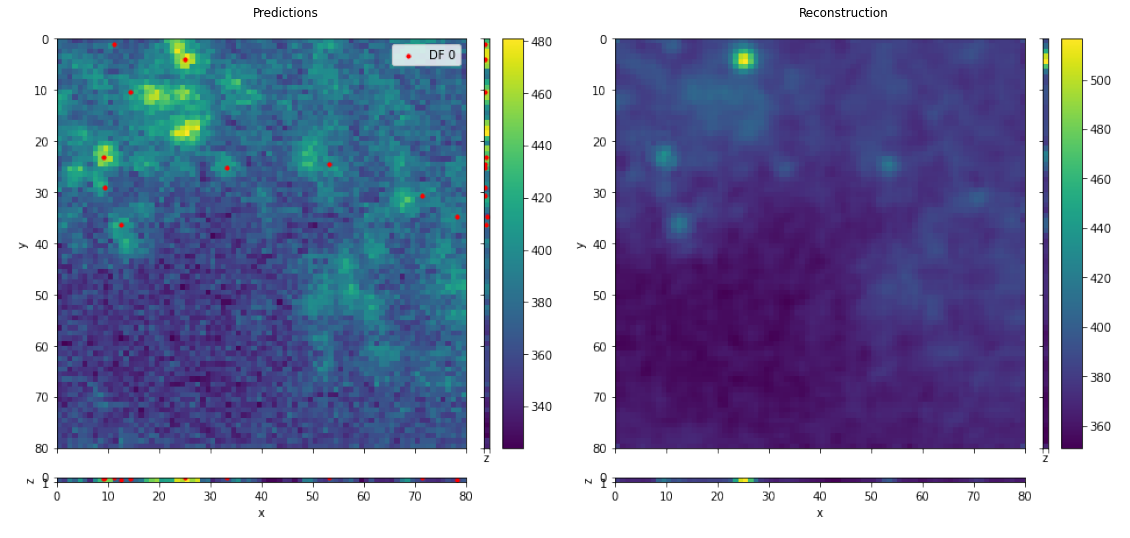

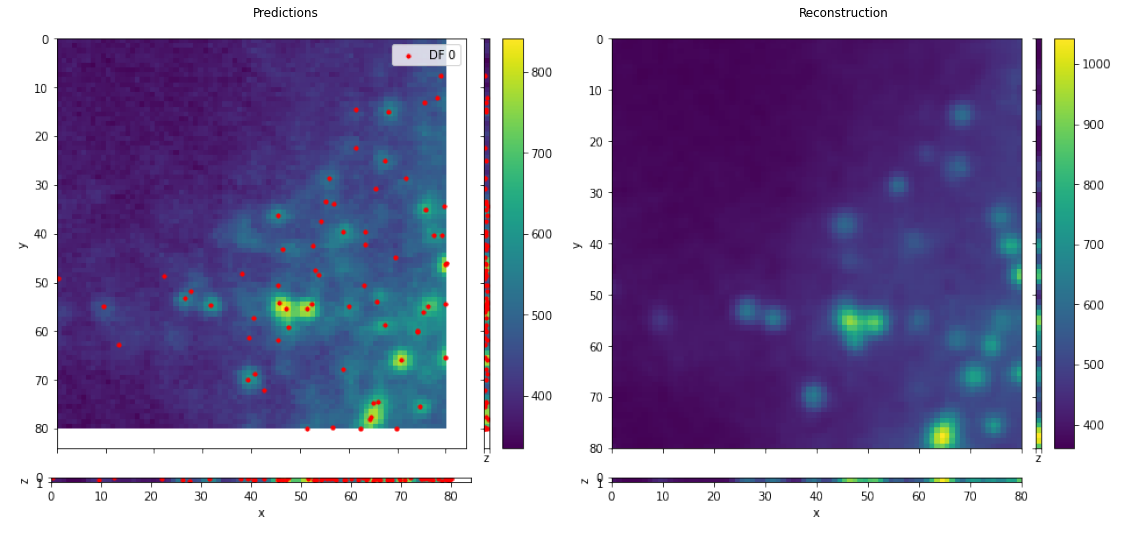

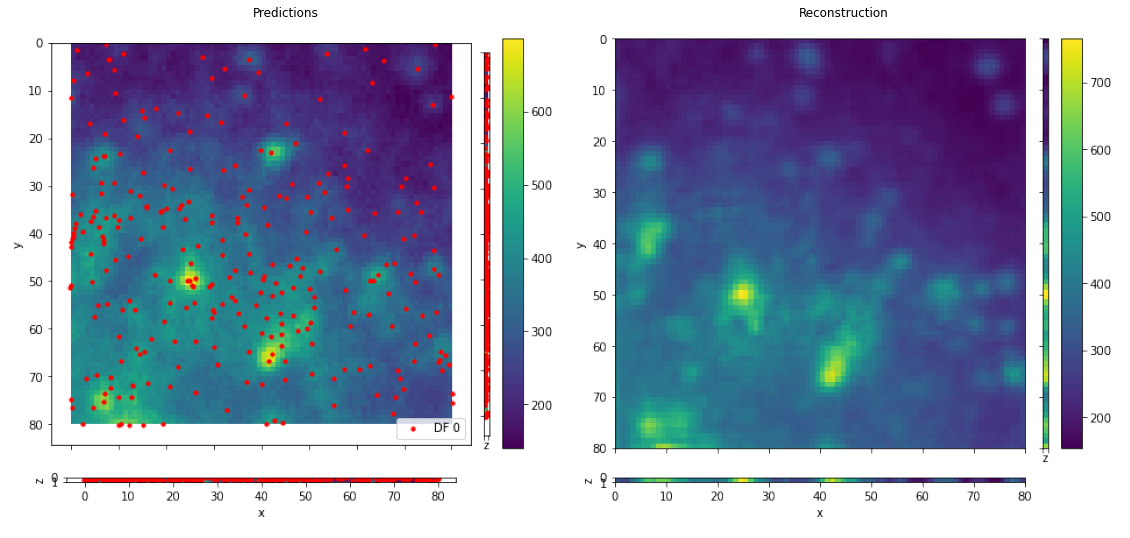

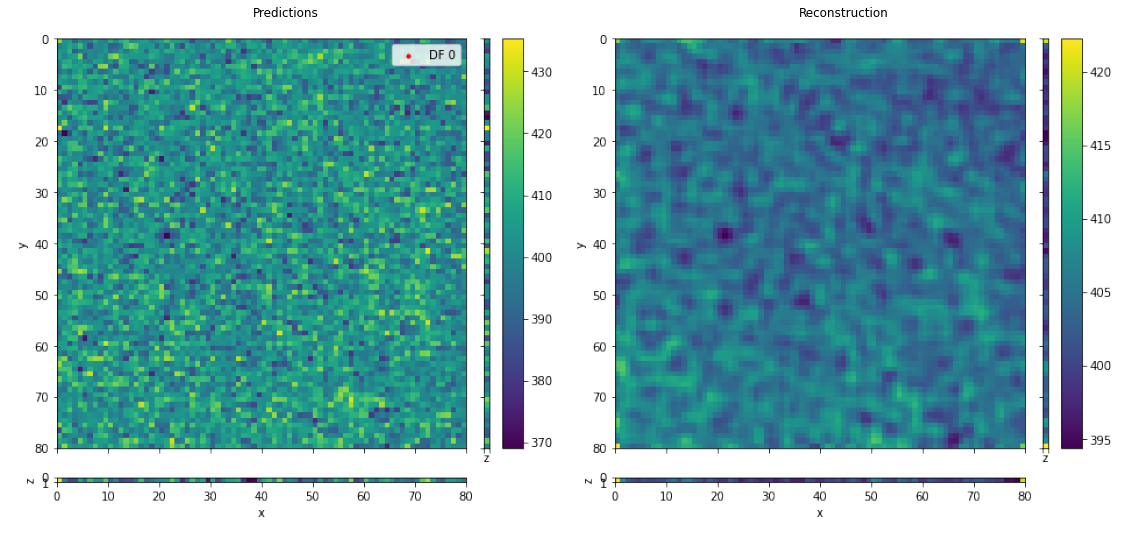

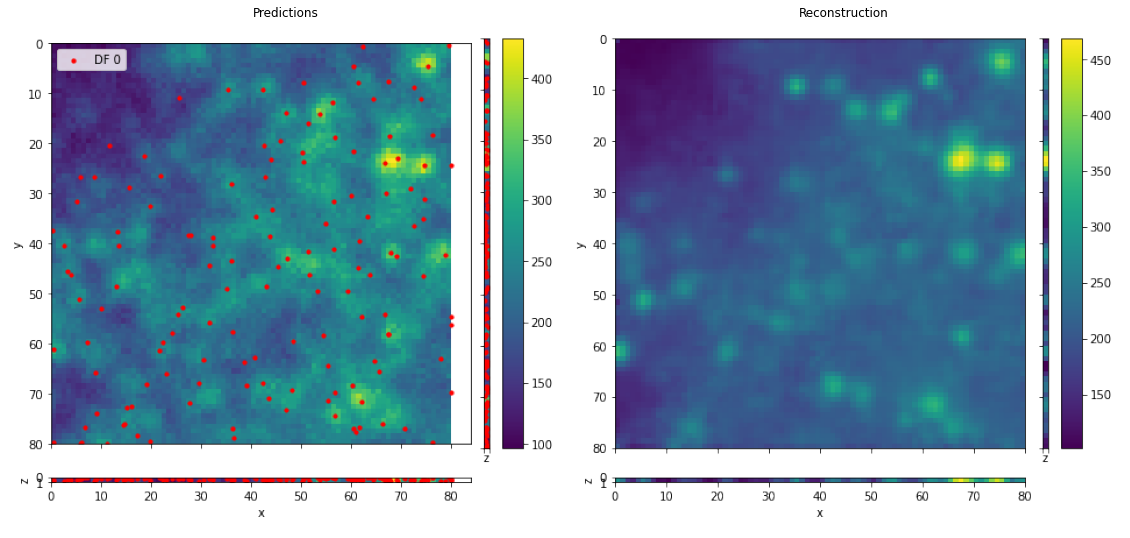

In [17]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=6, plot='rec', crop_sz_xy=80)

In [18]:
cfg.foci.n_foci_avg = 0
cfg.training.bs = 10
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [19]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *

# micro.psf_noise = 0.4

with torch.no_grad():
    x, local_rate, background = next(iter(decode_dl))
    sim_vars = PointProcessUniform(local_rate*1.,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z).sample()
    xsim = micro(*sim_vars, add_noise=True)
    xsimn = micro.noise(xsim, background).sample()

    gt_vars = sim_vars[:-1]
    gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

    print(len(gt_df))

    model.eval().cuda()
    res_dict = model(xsimn.cuda())
    res_dict = model.tensor_to_dict(res_dict)
#     res_dict['xyzi_mu'][:,3:] = res_dict['xyzi_mu'][:,3:]# * 0  + torch.tensor(gt_ints)[:,:,None,None,None].cuda()
#     res_dict['xyzi_sigma'][:,3:] = res_dict['xyzi_sigma'][:,3:] 
    count_prob, spatial_prob = PointProcessGaussian(**res_dict).log_prob(*sim_vars[:5], 
                                                  n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
    
    pred_df = post_proc.get_df(res_dict)

514


In [22]:
# x_nobg = xsim + background*0 + background.mean()
i = 0

# fig, ax = plot_3d_projections(x[i,0])
gt_sub = gt_df
pred_sub = nm_to_px(pred_df)
# scat_3d_projections(ax, [gt_sub, pred_sub])

perf, matches, _ = matching(px_to_nm(gt_sub), px_to_nm(pred_sub), tolerance=500, print_res=True)

Recall: 0.922
Precision: 0.958
Jaccard: 88.598
RMSE_vol: 49.025
Eff_3d: 72.965
FN: 40.0 FP: 21.0
Num. matches: 474.000
Shift: 0.01,0.63,-1.94


In [79]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate*1. ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background*0 + background.mean()).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, xrec


In [81]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 5, micro,model, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z)
perf, pred_df, matches, rec = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.883
Precision: 0.989
Jaccard: 87.444
RMSE_vol: 54.918
Eff_3d: 69.807
FN: 411.0 FP: 36.0
Num. matches: 3113.000
Shift: -2.03,-2.44,0.00


If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [492]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ae_2/shuffle_ch:Falsexenabled:Truexseed:1///train.yaml')

In [493]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [568]:
from monai.inferers import sliding_window_inference
def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    
    mixed_dfs = []
    
    for i in range(2):
    
        pred_df = DF()
        with torch.no_grad():
            for p in image_paths:
                print(p.split('/')[-1])
                img = load_tiff_image(p)[None]

                n_chans = img.shape[1]
                print(img.shape)
                z, y, x = img.shape[-3:]
                
#                 if i:
#                     ch_perm = list(np.random.permutation(np.arange(16)))
#                 else:
#                     ch_perm = np.arange(16)

                if i:
                    inp = img.flip(3)
                else:
                    inp = img
                output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                if i:
                    output = output.flip(3)
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                i_df.loc[:,'frame_idx'] = 0
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()

#             pred_df[[f'int_{i}' for i in ch_perm]] = pred_df[[f'int_{i}' for i in np.arange(n_chans)]].values
            mixed_dfs.append(pred_df)
            
    return mixed_dfs

In [569]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
bench_df = bench_df[bench_df['gene'] != 'MALAT1']

13832


In [570]:
image_paths = sorted(glob.glob(cfg.data_path.image_path))
image_paths = ['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff']
inf_dfs = merfish_predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')
# inf_df.to_csv(f'../data/results/MERFISH/test.csv', index=False)

img_stack.tiff
torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  59344
img_stack.tiff
torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  59816


In [571]:
inf_dfs = [exclude_borders(df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100]) for df in inf_dfs]
inf_dfs = [get_code_from_ints(df, code_ref, targets, vcorrcoef) for df in inf_dfs]
inf_dfs = [df[df['gene'] != 'MALAT1'] for df in inf_dfs]

In [572]:
res_df1 = inf_dfs[0]
res_df2 = inf_dfs[1]

In [574]:
_,matches,shift = matching(res_df1.nsmallest(35000, 'code_err'), res_df2.nsmallest(35000, 'code_err'), tolerance=200)

Recall: 0.807
Precision: 0.807
Jaccard: 67.633
RMSE_vol: 97.592
Eff_3d: 41.445
FN: 6758.0 FP: 6758.0
Num. matches: 28242.000
Shift: 0.02,3.41,0.00


In [575]:
print((matches['gene_pred']==matches['gene_tar']).sum()/len(matches))
matches = matches[matches['gene_pred']==matches['gene_tar']]

0.868458324481269


In [576]:
res_dfc = res_df1.set_index('loc_idx').loc[matches['loc_idx_tar']]
res_dfc['loc_idx'] = res_dfc.index
res_dfc = res_dfc.reset_index(drop=True)

In [542]:
matches, bench_match = match_bench(res_df1, bench_df)

[79.1546510138032, 76.45107093092251, 0.0]
Recall: 0.899
Precision: 0.220
Jaccard: 21.472
RMSE_vol: 88.157
Eff_3d: 9.947
FN: 1269.0 FP: 40007.0
Num. matches: 11286.000
Shift: 3.25,3.40,0.00


In [520]:
matches, bench_match = match_bench(res_dfc, bench_df)

[86.46632206394477, 85.95934886888698, 0.0]
Recall: 0.772
Precision: 0.536
Jaccard: 46.240
RMSE_vol: 85.691
Eff_3d: 31.255
FN: 2864.0 FP: 8403.0
Num. matches: 9691.000
Shift: 1.71,1.76,0.00


12555 15000


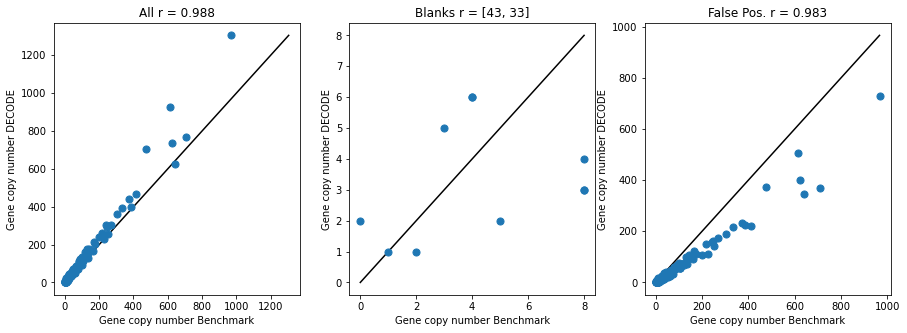

In [577]:
plot_gene_panels(res_df1.nsmallest(15000, 'code_err'), bench_match, matches, targets)

12555 15000


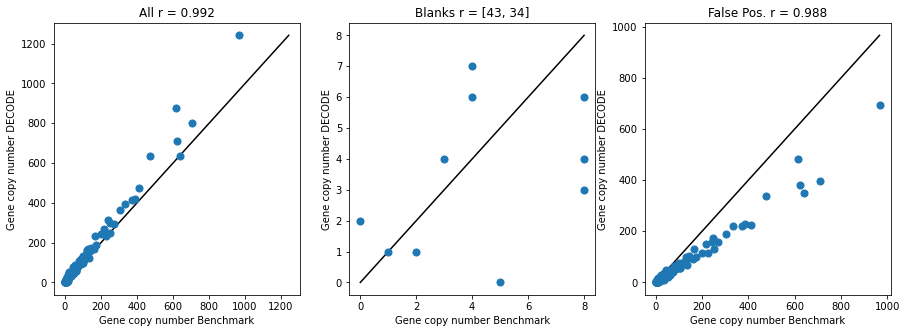

In [579]:
plot_gene_panels(res_dfc.nsmallest(15000, 'code_err'), bench_match, matches, targets)

In [580]:
res_dfc.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [599]:
img_stack_o = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/img_stack.tiff')
img_stack_s = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff')

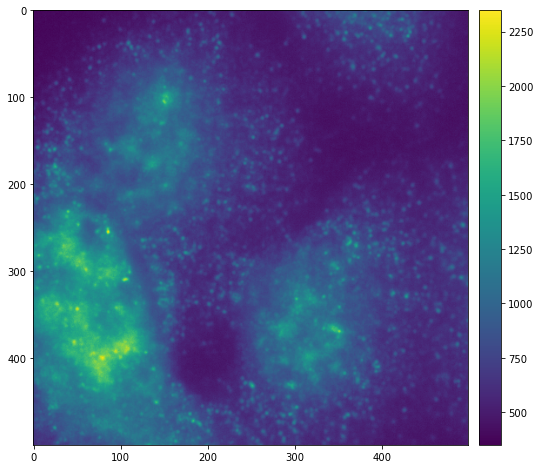

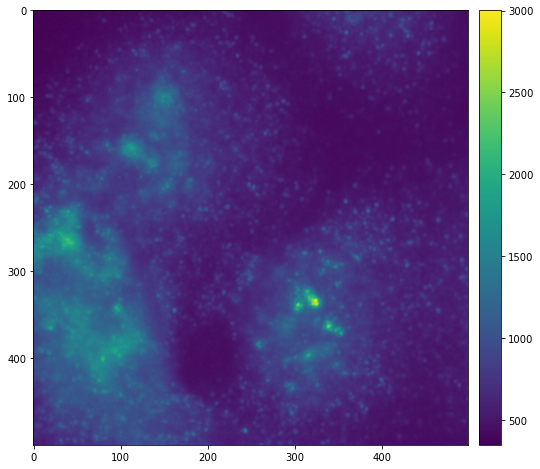

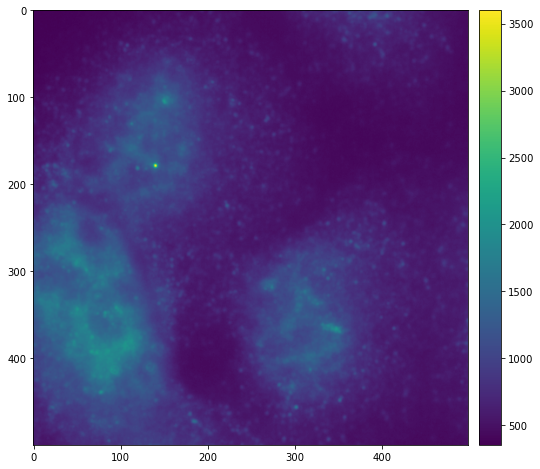

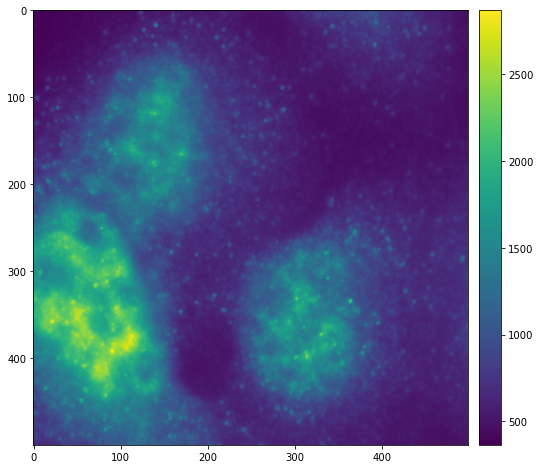

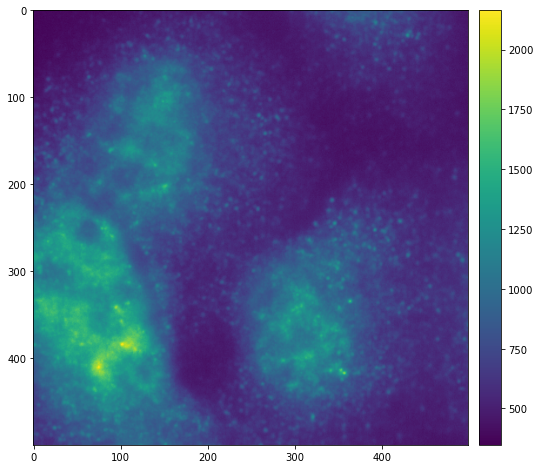

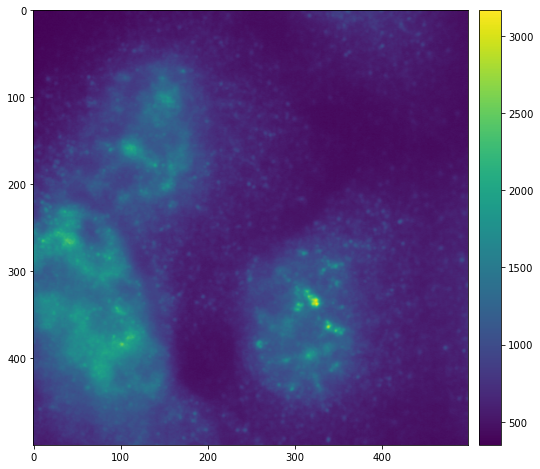

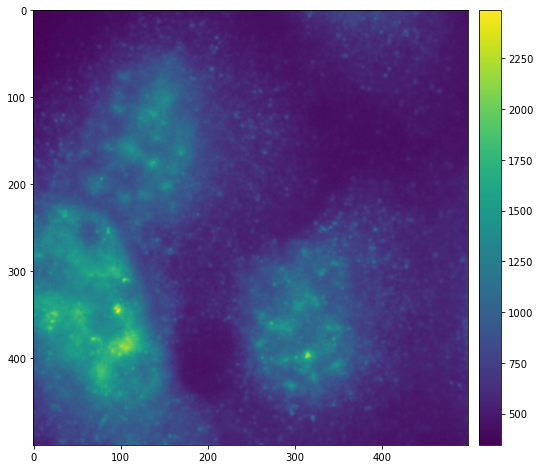

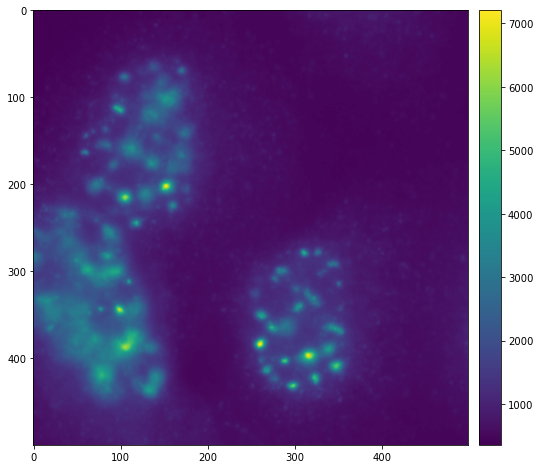

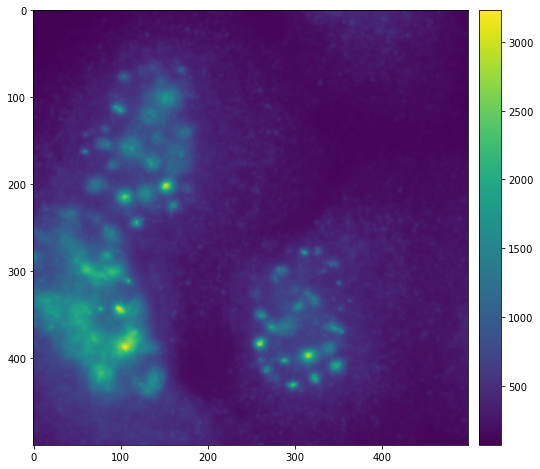

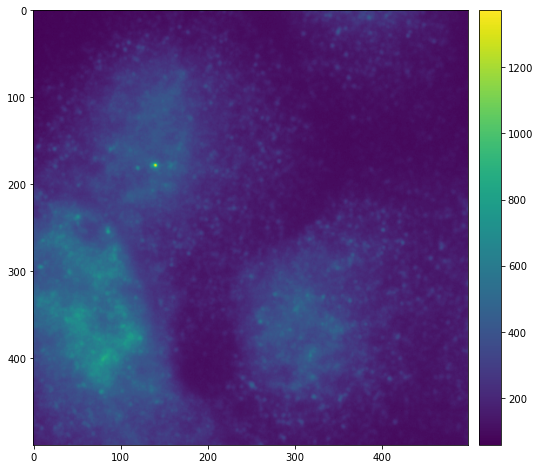

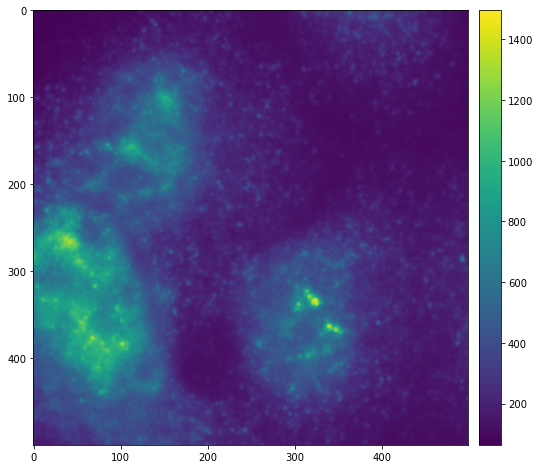

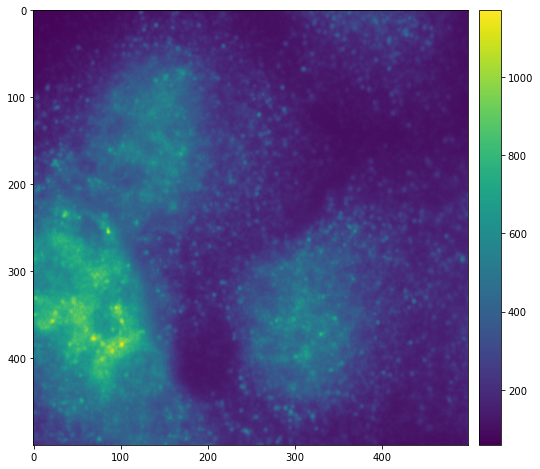

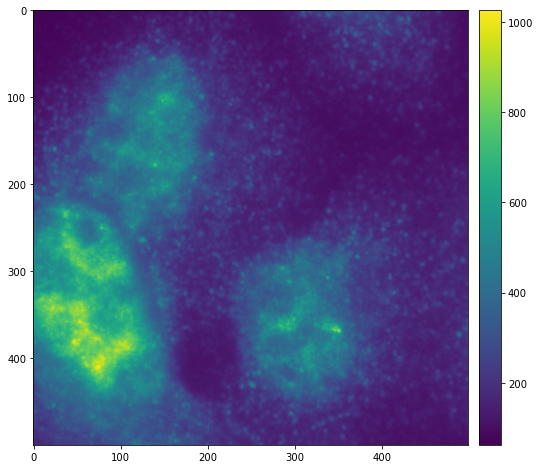

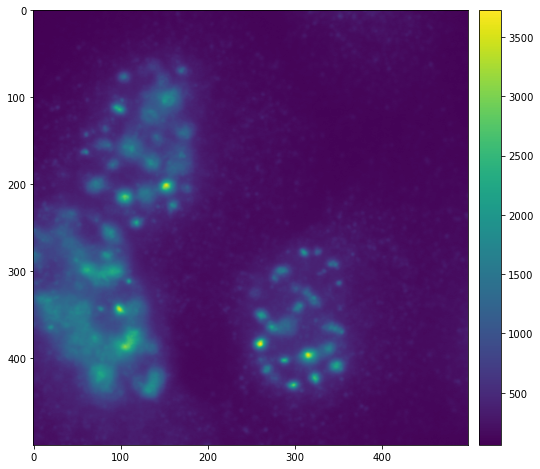

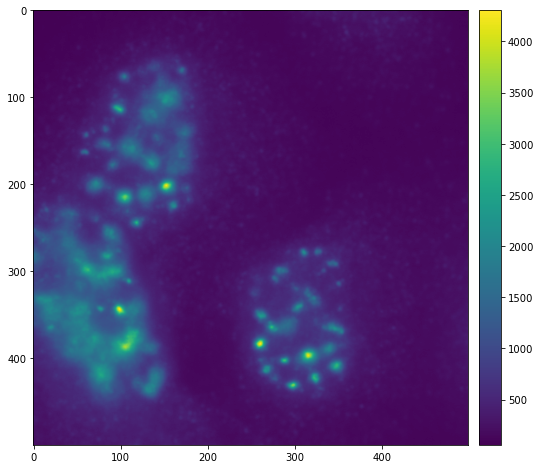

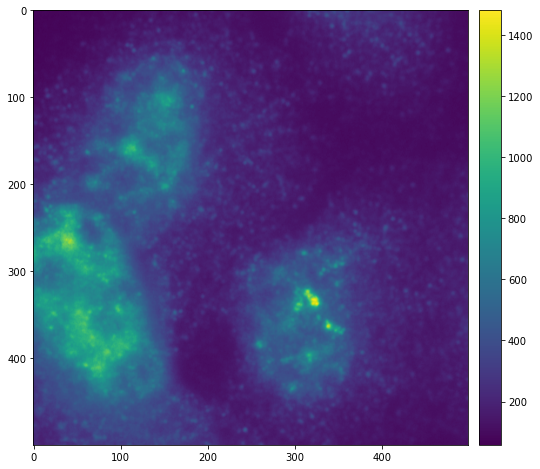

In [605]:
sl = np.s_[0,700:1200,300:800]
# malat = 7,  8, 13, 14
for i in range(16):

    plt.figure(figsize=(20,8))
    im = plt.imshow(img_stack[i][sl])
    add_colorbar(im)

In [604]:
sl = np.s_[:,:,500:1250,1100:1700]
sl = np.s_[:,:,:,:]
img = load_tiff_image(image_paths[0])
for i in range(16):

    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[i,0][sl[2:]])
    add_colorbar(im)
    sub_preds = crop_df(preds_px, sl)
    plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
    plt.show()

TypeError: 'NoneType' object is not subscriptable

In [268]:
inf_df

loc_idx  frame_idx              x              y     z      prob  \
0            0          0   89241.250000      -5.308199  50.0  0.603315   
1            1          0   89635.453125      -7.718092  50.0  0.623865   
2            2          0   90129.828125      -9.761763  50.0  0.603158   
3            3          0   90331.484375     -11.704487  50.0  1.000000   
4            4          0   90634.000000     -11.423206  50.0  1.000000   
...        ...        ...            ...            ...   ...       ...   
55399    55399          0  195960.234375  204776.890625  50.0  1.000000   
55400    55400          0  196279.531250  204728.921875  50.0  0.765807   
55401    55401          0  199060.671875  204774.125000  50.0  1.000000   
55402    55402          0  204458.781250  204686.421875  50.0  0.922645   
55403    55403          0  204726.593750  204727.593750  50.0  1.000000   

            int   int_sig      x_sig      y_sig  ...    int_11  int_sig_11  \
0      3.173387  2.874560  74.198654  59.556221  ...  0.002543    0.010202   
1      2.674512  2.572523  72.237984  54.646545  ...  0.001414    0.010121   
2      2.957641  2.935229  70.094833  51.175522  ...  0.001831    0.010180   
3      2.735931  2.568384  68.729408  51.582863  ...  0.001882    0.010113   
4      3.835938  2.640584  68.379959  52.237846  ...  0.003323    0.010070   
...         ...       ...        ...        ...  ...       ...         ...   
55399  0.003812  0.010001  43.978638  23.572756  ...  0.701596    0.021587   
55400  0.000562  0.010000  31.495127  35.259415  ...  0.172792    0.044272   
55401  1.670031  0.073135  26.117718  26.018900  ...  1.955726    0.087571   
55402  0.091328  0.010174  22.239372  31.865776  ...  0.674074    0.108814   
55403  0.035096  0.052102  55.389713  42.088726  ...  0.006067    0.010269   

         int_12  int_sig_12    int_13  int_sig_13    int_14  int_sig_14  \
0      0.000081    0.010002  0.000800    0.011936  0.032992    0.015809   
1      0.000083    0.010004  0.000536    0.011040  0.023822    0.012656   
2      0.000084    0.010006  0.000531    0.011292  0.025843    0.013329   
3      0.000080    0.010003  0.000437    0.010652  0.022488    0.012511   
4      0.000092    0.010002  0.000545    0.010529  0.024246    0.012040   
...         ...         ...       ...         ...       ...         ...   
55399  0.261016    0.010607  0.006019    0.010014  0.024257    0.010229   
55400  0.003539    0.010001  0.032229    0.012203  0.034647    0.010725   
55401  0.028940    0.010002  0.044841    0.010019  0.237867    0.010077   
55402  0.151397    0.010036  0.125268    0.010016  2.457803    0.216972   
55403  1.230594    0.125874  1.138647    0.311458  0.061497    0.014311   

         int_15  int_sig_15  
0      1.419214    0.233606  
1      1.248403    0.186593  
2      1.136480    0.240497  
3      1.368555    0.252216  
4      1.269829    0.227444  
...         ...         ...  
55399  5.270720    0.933748  
55400  0.021967    0.010109  
55401  2.014872    0.100571  
55402  0.072000    0.010009  
55403  2.241346    0.630612  

[55404 rows x 44 columns]